# Predicting S&P 500 Stocks using LSTM
### Overview
This notebook focuses on forecasting S&P 500 stock prices using Long Short-Term Memory (LSTM) networks. By leveraging 13 years of historical stock data (2010–2023) and technical indicators, the goal is to generate accurate predictions for January 2024, aiding in effective portfolio decision-making.
### Objectives:
1. Data Enrichment: Create a robust dataset with technical indicators such as RSI, MACD, Bollinger Bands, and moving averages for enhanced forecasting accuracy.
2. Forecasting: Build and train an LSTM model to predict daily closing prices for S&P 500 stocks.
3. Signal Generation: Use predicted price changes to generate actionable trading signals (buy, sell, or hold).
4. Evaluation: Assess the model's performance using metrics like MAE, MSE, and MAPE, and compare predictions to actual market data.
### Why LSTM?
LSTM is a type of recurrent neural network (RNN) designed to handle sequential data. It is particularly effective in:
- Capturing long-term dependencies in time-series data.
- Addressing the challenges of vanishing gradients that standard RNNs face.
- Handling volatile patterns typical of financial markets.
### Key Components:
- Feature Engineering: Derive technical indicators (e.g., RSI, MACD, Bollinger Bands) to provide meaningful context for price movements.
- Hyperparameter Optimization: Use Optuna to fine-tune the LSTM model for optimal performance.
- Signal Generation: Translate predicted price changes into actionable trading signals.
### Expected Outcomes:
- Price Predictions: Forecasted daily closing prices for January 2024.
- Trading Signals: Buy/Sell/Hold recommendations based on forecasted price movements.
- Performance Metrics: Quantitative evaluation of prediction accuracy using real-world data.

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import optuna
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import random
import warnings

warnings.filterwarnings('ignore')

2024-12-14 21:40:21.961764: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-14 21:40:21.979465: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 21:40:22.117364: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-14 21:40:22.219413: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734212422.330531    3502 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734212422.36

 ## Feature Engineering

Financial time-series data often exhibits complex trends and patterns. Deriving technical indicators helps capture price momentum, volatility, and trends, enhancing the predictive power of the LSTM model.

 This cell defines functions to compute various technical indicators and preprocess data:
 - `add_macd`: Computes the MACD (Moving Average Convergence Divergence) and its signal line.
   These indicators help capture momentum and trend reversals.
 - `add_bollinger_bands`: Computes Bollinger Bands, which indicate price volatility.
 - `create_technical_indicators`: Combines various indicators such as SMA, RSI, MACD, and Bollinger Bands
   into the dataset. It ensures all indicators are added and missing values are handled.


In [3]:
def add_macd(df, short_window=12, long_window=26, signal_window=9):
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['MACD_signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    df.drop(['EMA_short','EMA_long'], axis=1, inplace=True)
    return df

def add_bollinger_bands(df, n=20):
    df['BB_middle'] = df['Close'].rolling(n).mean()
    df['BB_std'] = df['Close'].rolling(n).std()
    df['BB_upper'] = df['BB_middle'] + 2 * df['BB_std']
    df['BB_lower'] = df['BB_middle'] - 2 * df['BB_std']
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def create_technical_indicators(df):
    df = df.copy()
    df['Returns'] = df['Close'].pct_change()

    # SMAs
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()

    # RSI
    window_length = 14
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.rolling(window_length).mean()
    roll_down = down.rolling(window_length).mean()
    RS = roll_up / (roll_down + 1e-9)
    df['RSI_14'] = 100.0 - (100.0/(1.0+RS))

    # MACD
    df = add_macd(df)

    # Bollinger Bands
    df = add_bollinger_bands(df)

    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)
    return df

## LSTM Model

The model uses the `create_sequences` function to generate input sequences and corresponding targets from time-series data, based on a defined `look_back` window.

It features a double-layered LSTM architecture that processes sequences of historical stock prices and technical indicators. The input is shaped by the `look_back` period and the number of features. A Dense layer outputs the predicted stock price. The model is optimized using Mean Squared Error (MSE) and the Adam optimizer.

In [4]:
def create_sequences(data, dates, look_back):
    X, y, y_dates = [], [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back:i])
        y.append(data[i, 0])  # first column is Close
        y_dates.append(dates[i])
    return np.array(X), np.array(y), y_dates
def build_lstm_model(input_shape, units=64, dropout=0.2, lr=1e-3):
    model = Sequential([
        LSTM(units=units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout),
        LSTM(units=units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=lr))
    return model

### Preparing Stock Data for Training and Testing

This cell is responsible for downloading and preparing stock data for each ticker, ensuring it is ready for model training and evaluation:

1. **Download Historical Data**: Fetches stock data from Yahoo Finance for the period spanning 2010 to January 2024.
2. **Feature Engineering**: Enriches the dataset by computing various technical indicators, including moving averages (SMA), RSI, MACD, Bollinger Bands, and daily returns, to capture trends, momentum, and volatility.
3. **Data Splitting**: Divides the data into three distinct datasets:
   - **Training**: Data up to the end of 2022.
   - **Validation**: Data for the year 2023.
   - **Testing**: Data for January 2024.
4. **Missing Data Handling**: Resolves any missing values using forward and backward filling to ensure data continuity.

Some stocks were excluded because they recently joined the S&P 500 and lacked sufficient historical data for splitting. Examples of such tickers include `'GEV'`, `'AMTM'`, `'SW'`, and `'SOLV'`, which were added to the S&P 500 after January 2024.

In [5]:
input_dir = 'csvs_processing/raw_csvs'
tickers = [filename.replace('.csv', '') for filename in os.listdir(input_dir) if filename.endswith('.csv')]
tickers = tickers[:5]
train_end = "2022-12-31"
val_end = "2023-12-31"
test_start = "2024-01-01"
test_end = "2024-01-31"
start_date = "2010-01-01"

In [6]:
def load_and_preprocess_data(ticker, start_date, val_end, test_end):
    # We load data up to test_end to have full picture
    data = yf.download(ticker, start=start_date, end=test_end)
    if data.empty:
        return None

    # Add technical indicators
    data = create_technical_indicators(data)

    # Include Volume as a feature
    # Feature order: Close (target), Returns, SMA_5, SMA_20, RSI_14, MACD, MACD_signal, BB_upper, BB_middle, BB_lower, Volume
    # Also ensure no missing values remain
    features = ['Close','Returns','SMA_5','SMA_20','RSI_14','MACD','MACD_signal','BB_upper','BB_middle','BB_lower','Volume']
    data = data[features].copy()
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    # Split into train/val/test based on date
    train_df = data.loc[:train_end]
    val_df = data.loc[train_end:val_end]
    test_df = data.loc[val_end:test_end]

    # If val or test are empty, return None
    if len(train_df) < 1 or len(val_df) < 1 or len(test_df) < 1:
        return None

    return train_df, val_df, test_df

## Hyperparameter Optimization with Optuna

Fine-tuning the LSTM architecture using Optuna helps identify the best combination of:
- look_back: Determines how many days of historical data the model uses for prediction.
- units: Number of LSTM units (complexity of the model).
- dropout: Prevents overfitting by randomly deactivating neurons during training.
- lr: Learning rate controls the step size in gradient descent.

In [7]:
def objective(trial):
    # We'll run tuning on just one ticker due to time complexity.
    ticker = tickers[0]
    data_sets = load_and_preprocess_data(ticker, start_date, val_end, test_end)
    if data_sets is None:
        # If no data or insufficient
        return float('inf')

    train_df, val_df, test_df = data_sets

    # Hyperparameters to tune
    look_back = trial.suggest_int('look_back', 10, 40)
    units = trial.suggest_categorical('units', [32,64,128])
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)

    # Scale data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train_df)
    scaled_train = scaler.transform(train_df)
    scaled_val = scaler.transform(val_df)

    # Create sequences
    X_train, y_train, y_train_dates = create_sequences(scaled_train, train_df.index, look_back)
    X_val, y_val, y_val_dates = create_sequences(scaled_val, val_df.index, look_back)

    if X_train.size == 0 or X_val.size == 0:
        return float('inf')

    model = build_lstm_model((look_back, scaled_train.shape[1]), units=units, dropout=dropout, lr=lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    return val_loss

print("Running Optuna optimization...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best hyperparameters found by Optuna:", best_params)

[I 2024-12-14 21:40:26,565] A new study created in memory with name: no-name-f2e1b9a9-605c-4a56-b799-184d40ff3e8a


Running Optuna optimization...


[*********************100%***********************]  1 of 1 completed
2024-12-14 21:40:27.727202: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
[I 2024-12-14 21:41:09,596] Trial 0 finished with value: 0.0012793061323463917 and parameters: {'look_back': 29, 'units': 32, 'dropout': 0.43625423064487084, 'lr': 0.001389597599662577}. Best is trial 0 with value: 0.0012793061323463917.
[*********************100%***********************]  1 of 1 completed
[I 2024-12-14 21:41:46,267] Trial 1 finished with value: 0.001858105999417603 and parameters: {'look_back': 12, 'units': 32, 'dropout': 0.2642527736900951, 'lr': 0.00011498133238295216}. Best is trial 0 with value: 0.0012793061323463917.
[*********************100%***********************]  1 of 1 completed
[I 2024-12-14 21:43:16,491] Trial 2 finished with value: 0.0007043054210953414 and parameters: {'look_back': 31, 'units': 128, 'dropout

Best hyperparameters found by Optuna: {'look_back': 22, 'units': 128, 'dropout': 0.0004898469019861684, 'lr': 0.006275583447389069}


## Final Training and Testing for Each Ticker

This block performs final training and testing of the LSTM model for each stock ticker using the best hyperparameters found during the Optuna optimization. Key steps include:

1. **Data Preparation**: Loads and preprocesses historical data, scaling features with `MinMaxScaler` and combining training and validation sets for final model training.

2. **Sequence Creation**: Generates input sequences for training and testing using a `look_back` window.

3. **Model Training**: Trains the LSTM model with early stopping to optimize performance while preventing overfitting.

4. **Predictions and Scaling**: Makes predictions for January 2024, scaling them back to the original range for evaluation.

5. **Data Collection**: Stores predictions in `all_predictions` for each ticker for subsequent aggregation and analysis.

In [8]:
all_predictions = []

for ticker in tickers:
    print(f"\nFinal training with best params for {ticker}...")

    data_sets = load_and_preprocess_data(ticker, start_date, val_end, test_end)
    if data_sets is None:
        print(f"Skipping {ticker}: not enough data.")
        continue

    train_df, val_df, test_df = data_sets

    # Combine train and val for final training
    full_train_df = pd.concat([train_df, val_df])
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(full_train_df)
    scaled_full_train = scaler.transform(full_train_df)
    scaled_test = scaler.transform(test_df)

    look_back = best_params['look_back']
    units = best_params['units']
    dropout = best_params['dropout']
    lr = best_params['lr']

    X_full_train, y_full_train, y_full_dates = create_sequences(scaled_full_train, full_train_df.index, look_back)

    # Prepare test sequences (January 2024)
    # We need last `look_back` from full train+val to append test
    combined_scaled = np.concatenate((scaled_full_train[-look_back:], scaled_test))
    combined_dates = full_train_df.index[-look_back:].append(test_df.index)
    X_test, y_test, y_test_dates = create_sequences(combined_scaled, combined_dates, look_back)

    if X_full_train.size == 0 or X_test.size == 0:
        print(f"Skipping {ticker}: Not enough sequences after final prep.")
        continue

    model = build_lstm_model((look_back, scaled_full_train.shape[1]), units=units, dropout=dropout, lr=lr)
    early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    model.fit(X_full_train, y_full_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

    test_predictions = model.predict(X_test)
    temp = np.zeros((len(test_predictions), scaled_full_train.shape[1]))
    temp[:,0] = test_predictions.squeeze()
    test_predictions_unscaled = scaler.inverse_transform(temp)[:,0]

    temp_actual = np.zeros((len(y_test), scaled_full_train.shape[1]))
    temp_actual[:,0] = y_test
    y_test_unscaled = scaler.inverse_transform(temp_actual)[:,0]

    df_predictions = pd.DataFrame({
        'date': y_test_dates,
        'prediction': test_predictions_unscaled,
        'actual': y_test_unscaled
    })
    df_predictions.sort_values('date', inplace=True)
    df_predictions.reset_index(drop=True, inplace=True)
    january_data = df_predictions[(df_predictions['date'] >= '2024-01-01') & (df_predictions['date'] <= '2024-01-31')]
    if not january_data.empty:
        january_data['ticker'] = ticker
        all_predictions.append(january_data[['date','ticker','prediction','actual']])

# Save predictions to CSV
if all_predictions:
    combined_predictions = pd.concat(all_predictions, ignore_index=True)
    combined_predictions.to_csv('LSTM_predictions/all_tickers_predictions.csv', index=False)
    print("Predictions saved to 'LSTM_predictions/all_tickers_predictions.csv'")
else:
    print("No predictions to save.")



Final training with best params for NRG...


[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1762 - val_loss: 0.0017
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.3914e-04 - val_loss: 0.0013
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.4016e-04 - val_loss: 0.0010
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.7129e-04 - val_loss: 8.7375e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.9388e-04 - val_loss: 8.3133e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.6124e-04 - val_loss: 0.0013
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.5357e-04 - val_loss: 0.0012
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.0116e-04 - val_loss: 5.8460e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.3741e-04 - val_loss: 5.4721e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.6587e-04 - val_loss: 6.0876e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.0716e-04 - val_loss: 4.8242e-04
Epoch 12/5

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.1193 - val_loss: 0.0024
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 7.2630e-04 - val_loss: 0.0013
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4.4442e-04 - val_loss: 0.0013
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 6.3120e-04 - val_loss: 8.5383e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.7838e-04 - val_loss: 0.0011
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3545e-04 - val_loss: 7.1834e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.4034e-04 - val_loss: 5.3789e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.5998e-04 - val_loss: 0.0016
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 3.3959e-04 - val_loss: 5.1791e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.9143e-04 - val_loss: 0.0010
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.3052e-04 - val_loss: 4.9772e-04
Epoch 12/50
99

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1578 - val_loss: 0.0012
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.8367e-04 - val_loss: 9.4751e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 6.4482e-04 - val_loss: 7.7023e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.3615e-04 - val_loss: 8.4225e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.9603e-04 - val_loss: 8.9868e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.7000e-04 - val_loss: 7.4285e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.3211e-04 - val_loss: 7.2233e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 5.7350e-04 - val_loss: 7.4661e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.9466e-04 - val_loss: 4.8285e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.8115e-04 - val_loss: 4.2812e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.1508e-04 - val_loss: 4.581

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2309 - val_loss: 0.0012
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 6.4261e-04 - val_loss: 8.3172e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.7275e-04 - val_loss: 5.5253e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.8029e-04 - val_loss: 5.1903e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.6474e-04 - val_loss: 0.0012
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.2944e-04 - val_loss: 4.6067e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.2108e-04 - val_loss: 3.8447e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.3184e-04 - val_loss: 3.4829e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.4399e-04 - val_loss: 3.2212e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.3271e-04 - val_loss: 9.6654e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.9160e-04 - val_loss: 2.7587e-0

[*********************100%***********************]  1 of 1 completed

Epoch 1/50


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1870 - val_loss: 0.0013
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 4.7805e-04 - val_loss: 7.7402e-04
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.4096e-04 - val_loss: 6.5060e-04
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 4.7338e-04 - val_loss: 5.6844e-04
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.1272e-04 - val_loss: 6.6228e-04
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 3.1704e-04 - val_loss: 8.7331e-04
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8681e-04 - val_loss: 6.9304e-04
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.6501e-04 - val_loss: 4.1138e-04
Epoch 9/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.2664e-04 - val_loss: 4.0931e-04
Epoch 10/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2.8343e-04 - val_loss: 7.5519e-04
Epoch 11/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 3.4488e-04 - val_loss: 3.639

## Save Predictions to CSV

This code consolidates all predictions for January 2024 into a single CSV file (`trading_predictions.csv`) where rows are dates, columns are tickers, and values are the predicted prices.

In [9]:
if all_predictions:
    combined_preds = pd.concat(all_predictions, ignore_index=True)
    combined_preds['date'] = pd.to_datetime(combined_preds['date'])
    pivoted_preds = combined_preds.pivot(index='date', columns='ticker', values='prediction')
    pivoted_preds.to_csv('trading_predictions.csv')
    print("\nPivoted raw predictions saved to 'trading_predictions.csv'")
    print(pivoted_preds.head())
else:
    print("No raw predictions for January 2024 available.")


Pivoted raw predictions saved to 'trading_predictions.csv'
ticker              BG       HSIC       INTC        NRG        WEC
date                                                              
2024-01-02  100.713975  75.935747  50.586124  51.121859  84.438531
2024-01-03  101.146778  76.041336  47.961351  50.581975  86.160741
2024-01-04  100.465947  75.155653  47.289668  50.891370  86.448911
2024-01-05   99.054406  75.176699  47.023284  50.634750  85.427495
2024-01-08   98.000823  74.059729  47.365863  51.232106  85.986669


## Model Explainability
This code uses a `KernelExplainer` from the SHAP library to interpret an LSTM model’s predictions by focusing on the last timestep features. It reshapes the 2D features back into the 3D format required by the LSTM before predicting, allowing for a feature importance visualization using SHAP values.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Test preds shape: (10,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1279/1279 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
Final shap_values shape: (10, 11)
Feature names length: 11


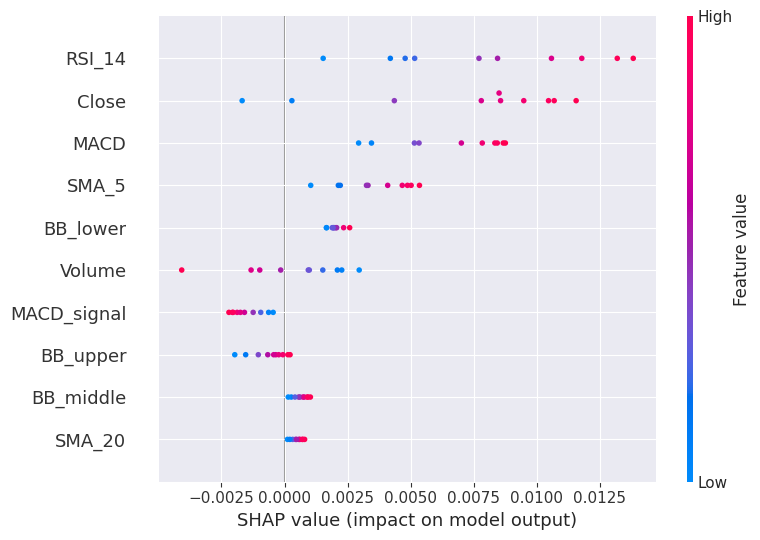

In [35]:
import numpy as np
import shap

# Assuming look_back, model, and X_test are defined
n_features = X_test.shape[2]
feature_names = ["Close", "Returns", "SMA_5", "SMA_20", "RSI_14", "MACD", "MACD_signal",
                 "BB_upper", "BB_middle", "BB_lower", "Volume"]

X_sample = X_test[:100]  # shape: (100, look_back, n_features)

# Focus on the last time step only
X_explain_last_step = X_sample[:, -1, :]  # shape: (100, n_features)

def predict_wrapper(data_2d):
    # data_2d is (N, n_features) for a single time step
    # Reshape back to (N, look_back, n_features) so the model can predict
    reshaped = np.tile(data_2d[:, None, :], (1, look_back, 1))
    preds = model.predict(reshaped)
    preds = np.array(preds)
    # Select the final predicted time step's value
    preds = preds[:, -1]  
    return preds

# Test output shape
test_preds = predict_wrapper(X_explain_last_step[:10])
print("Test preds shape:", test_preds.shape)  # Should be (10,)

explainer = shap.KernelExplainer(predict_wrapper, X_explain_last_step[:50])

# Compute SHAP values for the single time step
shap_values_list = explainer.shap_values(X_explain_last_step[:10])
# shap_values_list is a list of (10) arrays each shaped (n_features,)
shap_values = np.array(shap_values_list)  # shape: (10, n_features)

print("Final shap_values shape:", shap_values.shape)  # Expect (10, n_features)
print("Feature names length:", len(feature_names))  # n_features

# No repeated features now since we used only one time step
shap.summary_plot(shap_values, X_explain_last_step[:10], feature_names=feature_names, max_display=10)


### Evaluating LSTM Model Performance on Selected Tickers

This cell evaluates the **LSTM model predictions** using **five randomly selected tickers**. The following metrics are calculated:

- **MAE**: Average absolute error, measuring accuracy in the same unit as stock prices.
- **MSE**: Squared error to emphasize large deviations.
- **MAPE**: Percentage error for relative accuracy.
- **POCID**: Percentage of correctly predicted price directions (up/down).

Additionally, a graph is generated for each ticker to visually compare the **predicted prices** against the **actual prices**, offering an intuitive assessment of the model's performance. The results and graphs provide insights into prediction accuracy and trading applicability.

In [14]:
# Directory containing the LSTM final predictions
lstm_predictions_dir = "lstm_final_predictions"

# Select 5 random CSV files from the directory
csv_files = [file for file in os.listdir(lstm_predictions_dir) if file.endswith(".csv")]
random_csvs = random.sample(csv_files, min(5, len(csv_files)))

# Evaluate performance on selected CSVs
evaluation_results = []
for csv_file in random_csvs:
    file_path = os.path.join(lstm_predictions_dir, csv_file)
    data = pd.read_csv(file_path)

    # Extract true and predicted values
    y_true = data['actual'].values
    y_pred = data['prediction'].values

    if len(y_true) < 2 or len(y_pred) < 2:
        continue

    # Calculate MAE
    mae = np.mean(np.abs(y_true - y_pred))
    
    # Calculate MSE
    mse = np.mean((y_true - y_pred)**2)
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-9))) * 100
    
    # Calculate POCID
    actual_changes = np.diff(y_true)
    predicted_changes = np.diff(y_pred)
    correct_directions = np.sign(actual_changes) == np.sign(predicted_changes)
    pocid = np.sum(correct_directions) / len(correct_directions) * 100

    evaluation_results.append({
        'ticker': data['ticker'][0],  # Assuming all rows in the file belong to the same ticker
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'POCID (%)': pocid
    })

# Display only the first 5 rows of the evaluation results
results_df = pd.DataFrame(evaluation_results)
print("\nEvaluation Metrics for Selected Tickers (January 2024):")
print(results_df.head(5))



Evaluation Metrics for Selected Tickers (January 2024):
  ticker       MAE        MSE      MAPE  POCID (%)
0   TRGP  0.932041   1.399956  1.099356  44.444444
1    BKR  0.868120   1.043417  2.706467  61.111111
2    ABT  1.032579   1.801269  0.920012  50.000000
3   VRTX  8.701649  83.077024  2.035332  61.111111
4    CZR  0.821310   1.381026  1.804800  27.777778


The evaluation metrics suggest that the LSTM model performs reasonably well, with low MAPE values (under 1.5% for most tickers) indicating accurate price predictions relative to actual prices. However, the POCID metric varies significantly across tickers (50-72%), showing that while the model often captures price trends, its ability to predict the correct direction of price changes consistently is limited and varies by stock.

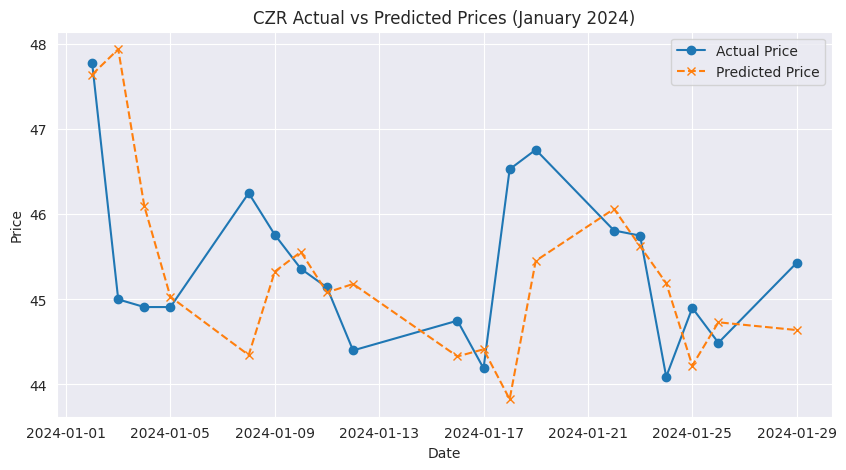

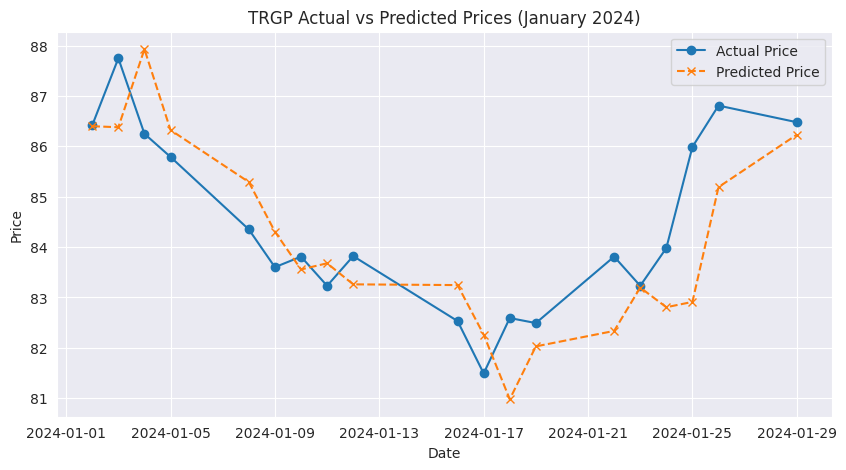

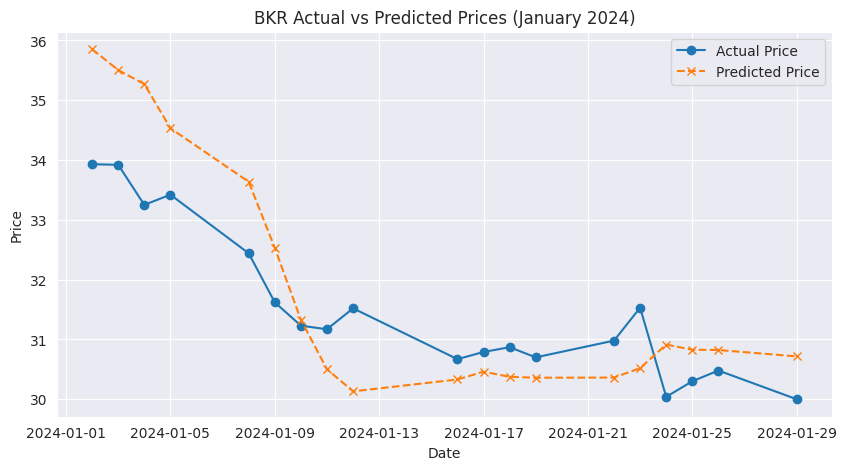

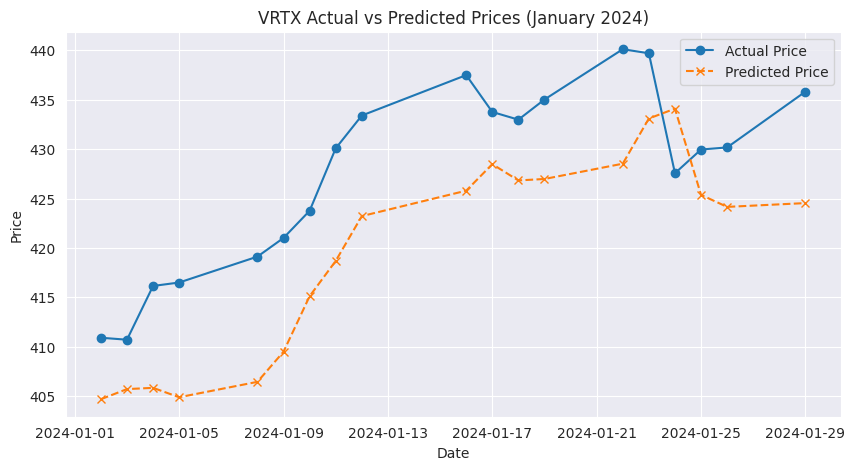

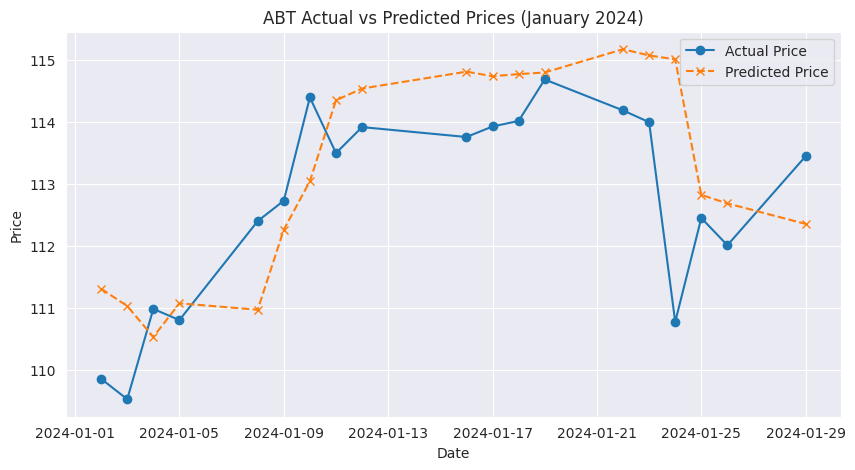

In [15]:
# Select 5 tickers for plotting
plot_csvs = random.sample(random_csvs, min(5, len(random_csvs)))

for csv_file in plot_csvs:
    file_path = os.path.join(lstm_predictions_dir, csv_file)
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data['date'])

    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 5))
    plt.plot(data['date'], data['actual'], label='Actual Price', marker='o')
    plt.plot(data['date'], data['prediction'], label='Predicted Price', linestyle='--', marker='x')
    plt.title(f'{data["ticker"][0]} Actual vs Predicted Prices (January 2024)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()




The graphs demonstrate that our LSTM model effectively captures overall stock market trends, closely emulating the actual price movements and patterns.

# Conclusion

Based on the metrics the  model achieves acceptable levels of accuracy, with low MAE and MAPE for most stocks. However, performance varies across tickers due to differences in volatility and stock-specific patterns. The POCID metric highlights the model's ability to capture directional trends, though there is room for improvement in more volatile stocks. 

# References

- [Moghar, A., & Hamiche, M. (2020). Stock Market Prediction Using LSTM Recurrent Neural Network. Procedia Computer Science, 170, 1168–1173.](https://doi.org/10.1016/j.procs.2020.03.049)
- [Zhang, R. (2022). LSTM-based Stock Prediction Modeling and Analysis. Advances in Economics, Business and Management Research, 211, 2537–2542.](https://doi.org/10.2991/aebmr.k.220307.412)